In [1]:

açıklama_metni = """
# Model Geliştirme Süreci ve Optimizasyon Kararları

4 Katmanlı CNN+DROPOUT modelimi yaptıktan sonra merak ettiğim şey katman sayısını arttırırsam performansımın artacağını düşünmem ve bunu test etmek istememdi.Bu sebeple 4 katmanlı CNN modelimin hiperparametrelerinde değişiklik yapmadan 6 katman ekledim. Derin öğrenme alanında, katman sayısını artırmanın her zaman performansı yükseltmediğini de bu deneyimimle net bir şekilde gördüm. 6 katmanlı CNN modelim, 4 katmanlı haline göre daha kötü sonuç verdi ve ben de bunun temelinde yatan sorunları araştırdım. Edindiğim bilgilere göre **overfitting eğilimi**, **öğrenme zorluğu** ve **mimarideki uyumsuzluk** buna sebep oluyordu ve ben de bu bilgileri dikkate alarak modelimde bazı değişikliklere gittim.

Model, derinliği nedeniyle eğitim verisindeki karmaşık rastgele desenleri ezberlemeye meyilliydi. Ancak her bir evrişim katmanının çıkışına uyguladığım yüksek Dropout oranı (0.25), bu ezberlemeyi engellerken, aynı zamanda modelin kritik ve yararlı özellikleri öğrenme yeteneğini de kısıtlıyordu. Bu durum, derinliğin getirdiği aşırı karmaşıklık potansiyelini yoğun Dropout ile birleştirerek modelimi dengesizliğe, yani bir çeşit **Underfitting/Overfitting karmaşasına** itmişti. En kritik sorun ise, 224 X 224 piksellik giriş görüntüsüne 6 kez 2 X 2 MaxPool uygulamamdan kaynaklanıyordu. Bu işlem, 512 kanallı son evrişim çıktısının uzamsal boyutunu 3.5 X 3.5 gibi tamsayı olmayan bir değere indiriyordu. Dolayısıyla eğitim süreci bozuldu ve tutarsız sonuçlar üretti.

# Uygulanan Düzeltmeler ve Optimizasyonlar

Bu sorunları gidermek ve 6 katmanlı modelimin potansiyelini tam olarak kullanmak adına aşağıdaki düzeltmeleri uyguladım:

1.  **Mimari Tutarlılık:** Giriş görüntüsü boyutunu 256 X 256'ya yükselttim ve fc1 katmanının giriş boyutunu da bu yeni, tutarlı boyuta (512 X 4 X 4) göre güncelledim.
2.  **Dropout Optimizasyonu:** Conv katmanlarındaki Dropout oranlarını 0.25'ten sırasıyla 0.1 ve 0.2'ye düşürerek, modelin temel özellikleri daha serbestçe öğrenmesine olanak tanıdım.
3.  **Eğitim Stratejisi Güçlendirmesi:** LR değerini daha güvenilir bir şekilde bulmak için Rastgele Arama epoch sayısını 10’a çıkardım ve nihai eğitimde epoch sayımı 30’a çıkardım. Aynı zamanda Erken Durdurma sabrını 7 epoch'a yükselttim. Bu son ayarlamalar, modelin doğal doğruluk dalgalanmaları sırasında yanlışlıkla durmasını engelledi ve derinliğin getirdiği daha yavaş yakınsama sürecine uyum sağlamasını sağladı.
"""

print("\n" + "="*70)
print("AÇIKLAMALARIM")
print("="*70 + "\n")
print(açıklama_metni)


AÇIKLAMALARIM


# Model Geliştirme Süreci ve Optimizasyon Kararları

4 Katmanlı CNN+DROPOUT modelimi yaptıktan sonra merak ettiğim şey katman sayısını arttırırsam performansımın artacağını düşünmem ve bunu test etmek istememdi.Bu sebeple 4 katmanlı CNN modelimin hiperparametrelerinde değişiklik yapmadan 6 katman ekledim. Derin öğrenme alanında, katman sayısını artırmanın her zaman performansı yükseltmediğini de bu deneyimimle net bir şekilde gördüm. 6 katmanlı CNN modelim, 4 katmanlı haline göre daha kötü sonuç verdi ve ben de bunun temelinde yatan sorunları araştırdım. Edindiğim bilgilere göre **overfitting eğilimi**, **öğrenme zorluğu** ve **mimarideki uyumsuzluk** buna sebep oluyordu ve ben de bu bilgileri dikkate alarak modelimde bazı değişikliklere gittim.

Model, derinliği nedeniyle eğitim verisindeki karmaşık rastgele desenleri ezberlemeye meyilliydi. Ancak her bir evrişim katmanının çıkışına uyguladığım yüksek Dropout oranı (0.25), bu ezberlemeyi engellerken, aynı zamanda mode

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score




In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Kullanılacak cihaz:", device)

transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

DATA_DIR = r'C:\Users\Kardelen\Desktop\dlp\garbage-dataset'
dataset = datasets.ImageFolder(DATA_DIR, transform=transform)
print("Toplam örnek sayısı:", len(dataset))
class_names = dataset.classes
print("Sınıflar:", class_names)

BATCH_SIZE = 32
targets = [s[1] for s in dataset.samples]

train_idx, temp_idx = train_test_split(
    range(len(dataset)), test_size=0.3, stratify=targets, random_state=42
)
temp_targets = [targets[i] for i in temp_idx]
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, stratify=temp_targets, random_state=42)

train_loader = DataLoader(Subset(dataset, train_idx), batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(Subset(dataset, val_idx), batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(Subset(dataset, test_idx), batch_size=BATCH_SIZE, shuffle=False)

print(f"Eğitim: {len(train_idx)}, Val: {len(val_idx)}, Test: {len(test_idx)}")




Kullanılacak cihaz: cuda
Toplam örnek sayısı: 19762
Sınıflar: ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']
Eğitim: 13833, Val: 2964, Test: 2965


In [4]:
class CNN6Layers(nn.Module):
    def __init__(self, num_classes=len(class_names)):
        super(CNN6Layers, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2) 
        self.drop1 = nn.Dropout(0.1)

        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.drop2 = nn.Dropout(0.1)

        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.drop3 = nn.Dropout(0.2)

        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.drop4 = nn.Dropout(0.2)

        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool5 = nn.MaxPool2d(2, 2)
        self.drop5 = nn.Dropout(0.25)

        self.conv6 = nn.Conv2d(256, 512, 3, padding=1)
        self.pool6 = nn.MaxPool2d(2, 2)
        self.drop6 = nn.Dropout(0.25)

        self.fc1 = nn.Linear(512 * 4 * 4, 1024)
        self.drop_fc = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, num_classes)
        
    def forward(self, x):
        x = self.drop1(self.pool1(F.relu(self.conv1(x))))
        x = self.drop2(self.pool2(F.relu(self.conv2(x))))
        x = self.drop3(self.pool3(F.relu(self.conv3(x))))
        x = self.drop4(self.pool4(F.relu(self.conv4(x))))
        x = self.drop5(self.pool5(F.relu(self.conv5(x))))
        x = self.drop6(self.pool6(F.relu(self.conv6(x))))
        
        x = x.view(x.size(0), -1)
        x = self.drop_fc(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x
    


In [5]:
NUM_TRIALS = 5
lr_candidates = 10**np.random.uniform(-5, -2, NUM_TRIALS)

best_lr = None
best_val_acc = 0.0
best_model_state = None

random_search_epochs = 10
def train_epoch(model, train_loader, optimizer, criterion, scheduler, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    scheduler.step()
    return running_loss / len(train_loader.dataset), correct / total

def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return val_loss / len(val_loader.dataset), correct / total

for i, lr in enumerate(lr_candidates):
    print(f"Deneme {i+1}/{NUM_TRIALS}: lr={lr:.6f}")
    model = CNN6Layers(num_classes=len(class_names)).to(device) 
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=random_search_epochs) 
    patience = 5
    counter = 0; best_trial_val_acc = 0.0

    for epoch in range(random_search_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, scheduler, device)
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

        print(f"  Epoch {epoch+1}/{random_search_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
        if val_acc > best_trial_val_acc:
            best_trial_val_acc = val_acc
            counter = 0
            trial_best_state = model.state_dict()
        else:
            counter +=1
            if counter >= patience:
                print(f"  Erken durdurma: {patience} epoch boyunca iyileşme yok.")
                break
    if best_trial_val_acc > best_val_acc:
        best_val_acc = best_trial_val_acc
        best_lr = lr
        best_model_state = trial_best_state
    del model, optimizer, criterion
    torch.cuda.empty_cache()

print(f"\n--- En iyi LR Bulundu: {best_lr:.6f}, En İyi Val Acc: {best_val_acc:.4f} ---")



Deneme 1/5: lr=0.001332
  Epoch 1/10 | Train Loss: 1.8300 | Val Loss: 1.5953 | Train Acc: 0.3745 | Val Acc: 0.4464
  Epoch 2/10 | Train Loss: 1.4540 | Val Loss: 1.3840 | Train Acc: 0.5005 | Val Acc: 0.5297
  Epoch 3/10 | Train Loss: 1.2749 | Val Loss: 1.1950 | Train Acc: 0.5660 | Val Acc: 0.6076
  Epoch 4/10 | Train Loss: 1.1317 | Val Loss: 1.1234 | Train Acc: 0.6135 | Val Acc: 0.6296
  Epoch 5/10 | Train Loss: 1.0118 | Val Loss: 1.0490 | Train Acc: 0.6569 | Val Acc: 0.6582
  Epoch 6/10 | Train Loss: 0.9048 | Val Loss: 0.9406 | Train Acc: 0.6941 | Val Acc: 0.6883
  Epoch 7/10 | Train Loss: 0.8038 | Val Loss: 0.8890 | Train Acc: 0.7288 | Val Acc: 0.7102
  Epoch 8/10 | Train Loss: 0.7273 | Val Loss: 0.8580 | Train Acc: 0.7589 | Val Acc: 0.7230
  Epoch 9/10 | Train Loss: 0.6761 | Val Loss: 0.8225 | Train Acc: 0.7700 | Val Acc: 0.7352
  Epoch 10/10 | Train Loss: 0.6322 | Val Loss: 0.8142 | Train Acc: 0.7901 | Val Acc: 0.7358
Deneme 2/5: lr=0.002226
  Epoch 1/10 | Train Loss: 1.9314 | Val L

In [6]:
model = CNN6Layers(num_classes=len(class_names)).to(device)
if best_model_state:
    model.load_state_dict(best_model_state)
else:
    print("Uyarı: best_model_state yüklenemedi. Yeni bir model başlatılıyor.")
    
final_training_epochs = 30
final_history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
final_optimizer = optim.Adam(model.parameters(), lr=best_lr)
final_criterion = nn.CrossEntropyLoss()
final_scheduler = lr_scheduler.CosineAnnealingLR(final_optimizer, T_max=final_training_epochs)
patience = 7
counter = 0; best_final_val_acc = 0.0

for epoch in range(final_training_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, final_optimizer, final_criterion, final_scheduler, device)
    val_loss, val_acc = validate_epoch(model, val_loader, final_criterion, device)

    final_history['train_loss'].append(train_loss)
    final_history['val_loss'].append(val_loss)
    final_history['train_acc'].append(train_acc)
    final_history['val_acc'].append(val_acc)

    print(f"Epoch {epoch+1} | LR: {final_optimizer.param_groups[0]['lr']:.6f} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    
    if val_acc > best_final_val_acc:
        best_final_val_acc = val_acc
        counter = 0
        torch.save(model.state_dict(), 'best_final_model.pth')
    else:
        counter +=1
        if counter >= patience:
            print(f"Erken durdurma! {patience} epoch boyunca iyileşme yok.")
            break



Epoch 1 | LR: 0.001230 | Train Loss: 0.7519 | Val Loss: 0.8900 | Val Acc: 0.7105
Epoch 2 | LR: 0.001220 | Train Loss: 0.7174 | Val Loss: 0.8485 | Val Acc: 0.7355
Epoch 3 | LR: 0.001203 | Train Loss: 0.6758 | Val Loss: 0.8656 | Val Acc: 0.7267
Epoch 4 | LR: 0.001180 | Train Loss: 0.6335 | Val Loss: 0.8520 | Val Acc: 0.7449
Epoch 5 | LR: 0.001151 | Train Loss: 0.6025 | Val Loss: 0.8465 | Val Acc: 0.7362
Epoch 6 | LR: 0.001116 | Train Loss: 0.5503 | Val Loss: 0.8883 | Val Acc: 0.7247
Epoch 7 | LR: 0.001075 | Train Loss: 0.5252 | Val Loss: 0.8683 | Val Acc: 0.7352
Epoch 8 | LR: 0.001030 | Train Loss: 0.4811 | Val Loss: 0.9197 | Val Acc: 0.7348
Epoch 9 | LR: 0.000979 | Train Loss: 0.4510 | Val Loss: 0.7495 | Val Acc: 0.7729
Epoch 10 | LR: 0.000925 | Train Loss: 0.3981 | Val Loss: 0.8622 | Val Acc: 0.7412
Epoch 11 | LR: 0.000868 | Train Loss: 0.3689 | Val Loss: 0.8648 | Val Acc: 0.7652
Epoch 12 | LR: 0.000807 | Train Loss: 0.3375 | Val Loss: 0.8428 | Val Acc: 0.7726
Epoch 13 | LR: 0.000745 |

In [7]:

model.load_state_dict(torch.load('best_final_model.pth', map_location=device, weights_only=True))

def evaluate_model(model, test_loader, device, class_names):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    test_acc = accuracy_score(all_labels, all_preds)
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    f1_per_class = f1_score(all_labels, all_preds, average=None)
    cm = confusion_matrix(all_labels, all_preds)
    return all_labels, all_preds, cm, f1_per_class, f1_macro, test_acc

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Tahmin Edilen Sınıf'); plt.ylabel('Gerçek Sınıf'); plt.title('Confusion Matrix')
    plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0); plt.tight_layout()
    plt.show()
    
def plot_f1_per_class(f1_scores, class_names):
    plt.figure(figsize=(12, 6))
    plt.bar(class_names, f1_scores, color='mediumseagreen')
    for i, score in enumerate(f1_scores):
        plt.text(i, score + 0.02, f'{score:.4f}', ha='center')
    plt.title('Sınıf Başına F1 Skoru'); plt.xlabel('Sınıf Adları'); plt.ylabel('F1 Skoru'); plt.ylim(0,1.0)
    plt.xticks(rotation=45, ha='right'); plt.tight_layout(); plt.show()

def plot_overall_metrics(test_acc, f1_macro):
    metrics = ['TEST Accuracy', 'Macro F1 Skoru']
    scores = [test_acc, f1_macro]
    plt.figure(figsize=(6,5))
    plt.bar(metrics, scores, color=['skyblue','lightcoral']); plt.ylim(0,1.0)
    for i, score in enumerate(scores):
        plt.text(i, score+0.02, f'{score:.4f}', ha='center', color='black')
    plt.title('Test Metrikleri'); plt.ylabel('Skor Değeri'); plt.tight_layout(); plt.show()

def plot_training_history(history):
    epochs = np.arange(1,len(history['train_loss'])+1)
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, history['train_loss'], 'bo', label='Training loss')
    plt.plot(epochs, history['val_loss'], 'r', label='Validation loss')
    plt.title('Eğitim & Val Loss'); plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.grid()
    plt.subplot(1,2,2)
    plt.plot(epochs, history['train_acc'], 'bo', label='Training acc')
    plt.plot(epochs, history['val_acc'], 'r', label='Validation acc')
    plt.title('Eğitim & Val Accuracy'); plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend(); plt.grid()
    plt.tight_layout(); plt.show()

def show_random_test_images(model, test_loader, device, class_names, num_samples=4):
    for images_batch, labels_batch in test_loader: break
    images_batch, labels_batch = images_batch.to(device), labels_batch.to(device)
    model.eval()
    with torch.no_grad():
        outputs_batch = model(images_batch)
    _, predicted_indices_batch = torch.max(outputs_batch, 1)
    random_indices = random.sample(range(len(images_batch)), num_samples)
    fig, axes = plt.subplots(1,num_samples,figsize=(12,3))
    for i, idx in enumerate(random_indices):
        ax = axes[i]
        img = images_batch[idx].cpu().numpy().transpose((1,2,0))
        mean = np.array([0.485,0.456,0.406]); std=np.array([0.229,0.224,0.225])
        img = np.clip(std*img + mean,0,1)
        true_label = class_names[labels_batch[idx].item()]
        pred_label = class_names[predicted_indices_batch[idx].item()]
        title_color = 'green' if true_label==pred_label else 'red'
        ax.set_title(f"P:{pred_label}\n(R:{true_label})", color=title_color)
        ax.imshow(img); ax.axis('off')
    plt.tight_layout(); plt.show()


Test Accuracy: 0.7987
Test Macro F1 Skoru: 0.7598


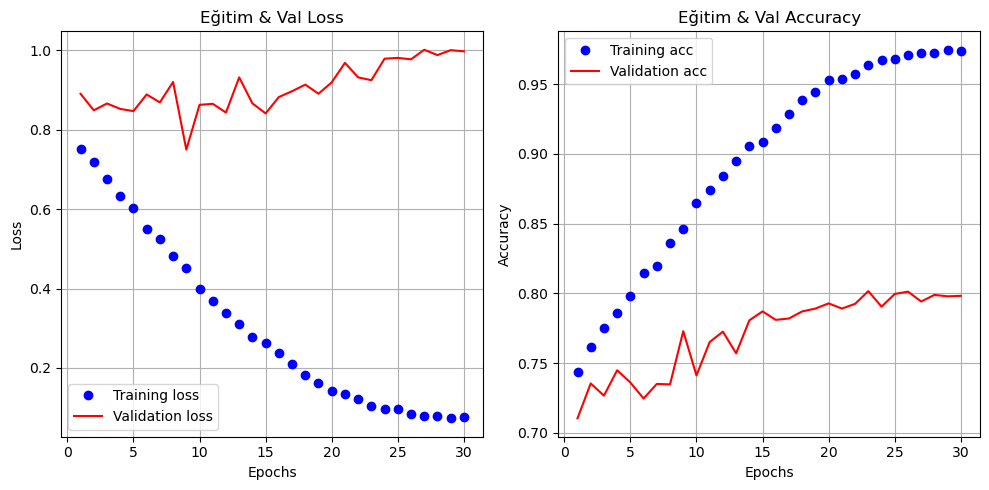

In [8]:
all_labels, all_preds, cm, f1_per_class, f1_macro, test_acc = evaluate_model(model, test_loader, device, class_names)

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Macro F1 Skoru: {f1_macro:.4f}")

plot_training_history(final_history)


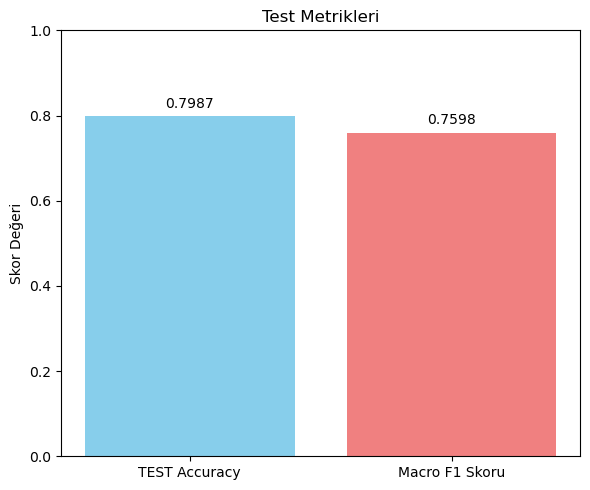

In [9]:
plot_overall_metrics(test_acc, f1_macro)

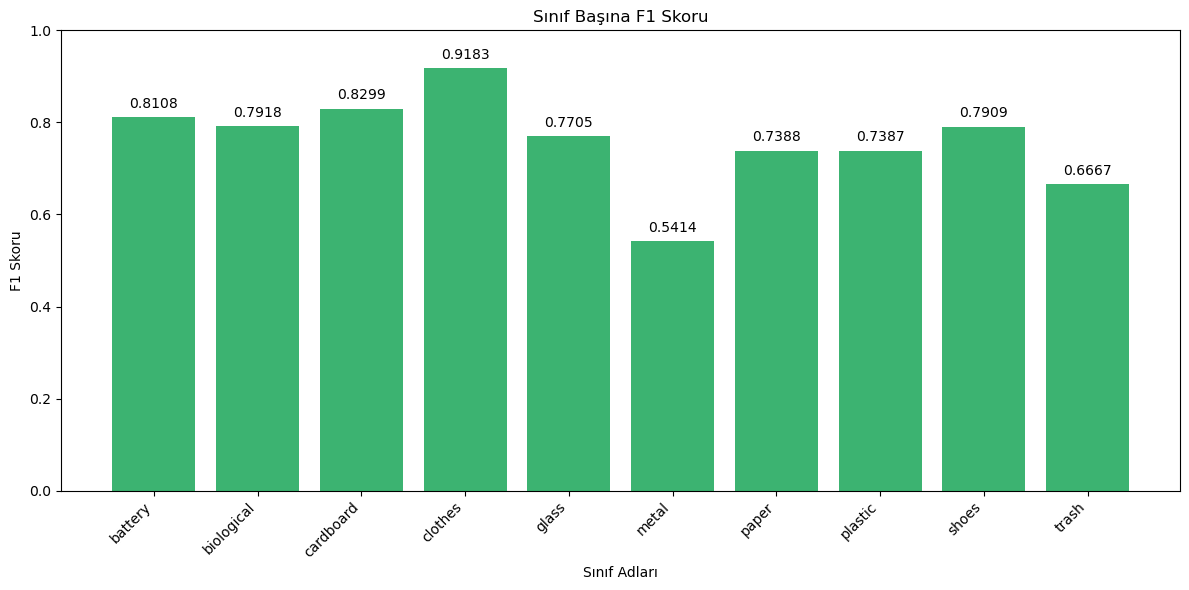

In [10]:
plot_f1_per_class(f1_per_class, class_names)


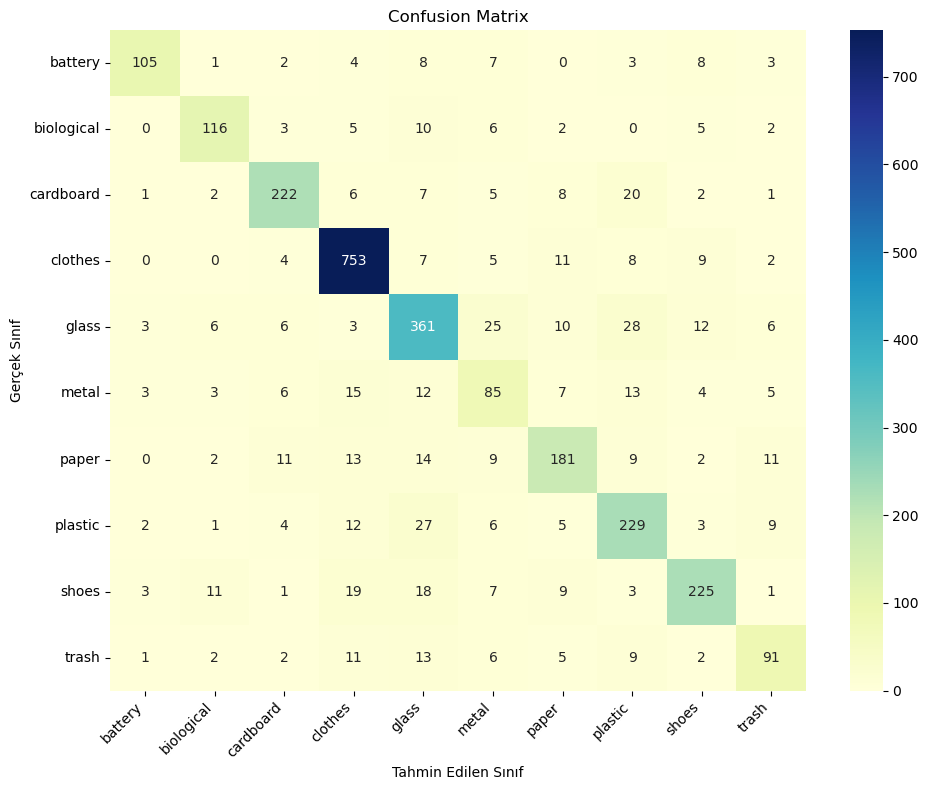

In [11]:
plot_confusion_matrix(cm, class_names)


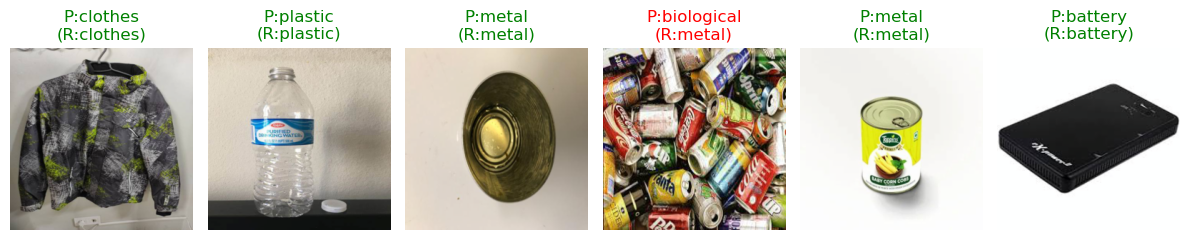

In [12]:
show_random_test_images(model, test_loader, device, class_names, num_samples=6)